In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 1.0
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5] if i in [0,3] else [0.25,0.25],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5] if i in [0,3] else [0.25,0.25],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9500]), and xy span tensor([0.2500, 0.2500])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9000]), and xy span tensor([0.2500, 0.2500])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.2000]), and xy 

In [8]:
def sig_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z > 0.4 and z <= 0.5: rad_length[7:,6:] = X0['uranium']
    return rad_length

In [9]:
def bkg_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    return rad_length

In [10]:
volume.load_rad_length(sig_rad_length)

In [11]:
volume._target = Tensor([X0['uranium']])

# Volume classifier

In [12]:
from tomopt.inference.volume import AbsVolumeInferer, AbsX0Inferer
from tomopt.inference.scattering import AbsScatterBatch


class BlockClassifierFromX0s(AbsVolumeInferer):
    def __init__(self, n_block_voxels:int, partial_x0_inferer: Type[AbsX0Inferer], volume:Volume, use_avgpool:bool=True, cut_coef=1e4, ratio_offset=-1, ratio_coef=5):
        super().__init__(volume=volume)
        self.use_avgpool, self.cut_coef,self.ratio_offset,self.ratio_coef = use_avgpool,cut_coef,ratio_offset,ratio_coef
        self.x0_inferer = partial_x0_inferer(self.volume)
        self.frac = n_block_voxels/self.volume.centres.numel()
        
        self.efficiencies: List[Tensor] = []
        self.efficiency: Optional[Tensor] = None
        self.scatter_batches = self.x0_inferer.scatter_batches
            

    def compute_efficiency(self, scatters: AbsScatterBatch) -> Tensor:
        return self.x0_inferer.compute_efficiency(scatters=scatters)
    

    def add_scatters(self, scatters: AbsScatterBatch) -> None:
        self.x0_inferer.add_scatters(scatters)
        self.efficiencies.append(self.compute_efficiency(scatters=scatters))

    def _get_weight(self) -> Tensor:
        """Maybe alter this to include resolution/pred uncertainties"""
        return self.efficiency.sum()

    def get_prediction(self) -> Tuple[Optional[Tensor], Optional[Tensor]]:
        self.efficiency = torch.cat(self.efficiencies, dim=0)
        vox_preds, vox_weights = self.x0_inferer.get_prediction()
        if self.use_avgpool:
            vox_preds = F.avg_pool3d(vox_preds[None], kernel_size=3, stride=1, padding=1, count_include_pad=False)[0]
        
        flat_preds = vox_preds.flatten()
        cut = flat_preds.kthvalue(1+round(self.frac*(flat_preds.numel()-1))).values
        
        w_bkg =  torch.sigmoid(self.cut_coef*(flat_preds-cut))
        w_blk = 1-w_bkg
        
        mean_bkg = (w_bkg*flat_preds).sum()/w_bkg.sum()
        mean_blk = (w_blk*flat_preds).sum()/w_blk.sum()
        
        r = 2*(mean_bkg-mean_blk)/(mean_bkg+mean_blk)
#         r = (r+self.ratio_offset)*self.ratio_coef
        pred = torch.sigmoid(r)
        weight = self._get_weight()
        return pred[None,None], weight

In [13]:
def get_sb(volume:Volume) -> Tensor:
    gen = MuonGenerator2016.from_volume(volume)
    mus = MuonResampler.resample(gen(250), volume=volume, gen=gen)
    mu = MuonBatch(mus, init_z=volume.h)
    volume(mu)
    
    sb = PanelScatterBatch(mu, volume)
    return sb

In [15]:
sb = get_sb(volume)

In [52]:
inf = BlockClassifierFromX0s(12, PanelX0Inferer, volume=volume, ratio_offset=-1, ratio_coef=5)

In [53]:
inf.add_scatters(sb)

In [54]:
pred, eff = inf.get_prediction(); pred

tensor([[0.7878]], grad_fn=<UnsqueezeBackward0>)

In [104]:
loss_func = VolumeClassLoss(x02id={X0['beryllium']:0, X0['uranium']:1}, target_budget=None)

In [56]:
pred.shape

torch.Size([1, 1])

In [57]:
l = loss_func(pred, eff, volume); l

Automatically setting cost coefficient to 0.0037498034071177244


tensor([0.0037], grad_fn=<AddBackward0>)

In [58]:
jacobian(l, volume.get_detectors()[0].panels[0].xy_span)

tensor([[0.0035, 0.0005]])

# Grad check

In [133]:
from fastprogress import master_bar, progress_bar
from lumin.utils.statistics import uncert_round

In [134]:
def set_span(volume, span):
    with torch.no_grad():
        for i,det in enumerate(volume.get_detectors()):
            for j,p in enumerate(det.panels):
                    p.xy_span.data = span

In [135]:
def set_xy_pos(volume, pos):
    with torch.no_grad():
        for i,det in enumerate(volume.get_detectors()):
            for j,p in enumerate(det.panels):
                    p.xy.data = pos

In [91]:
def set_res(volume, res):
    with torch.no_grad():
        for i,det in enumerate(volume.get_detectors()):
            for j,p in enumerate(det.panels):
                    p.resolution.data = res

In [92]:
def set_eff(volume, eff):
    with torch.no_grad():
        for i,det in enumerate(volume.get_detectors()):
            for j,p in enumerate(det.panels):
                    p.efficiency.data = eff

In [93]:
set_res(volume, Tensor([1e4]))

In [94]:
set_span(volume, Tensor([1.0,1.0]))

In [95]:
set_eff(volume, Tensor([0.90]))

In [96]:
set_xy_pos(volume, Tensor([0.5,0.5]))

In [97]:
def arb_rad_length(*, z: float, lw: Tensor, size: float) -> float:
    rad_length = torch.ones(list((lw / size).long())) * X0["beryllium"]
    if z > 0.4 and z <= 0.5:
        rad_length[1:4, 1:4] = X0["uranium"]
    return rad_length

In [128]:
def get_scatters(volume):
    gen = MuonGenerator2016.from_volume(volume)
    muons = MuonBatch(MuonResampler.resample(gen(250), volume=volume, gen=gen), volume.h, device=DEVICE)
    volume.load_rad_length(arb_rad_length, Tensor([X0["uranium"]]))
    volume(muons)
    return PanelScatterBatch(muons, volume)

In [99]:
def eval_model(sb, loss_func):
    inf = BlockClassifierFromX0s(12, PanelX0Inferer, volume=volume, ratio_offset=-1, ratio_coef=5)
    inf.add_scatters(sb)
    pred,weight = inf.get_prediction()
    loss_val = loss_func(pred, weight, volume)    
    return loss_val

In [113]:
def get_grad(loss, volume):
    grad_mean = []
    ok = True
    for i,det in enumerate(volume.get_detectors()):
        for j,p in enumerate(det.panels):
            grad = jacobian(loss, p.xy_span)
            ok *= ~grad.isnan().any()
            grad_mean.append(grad.detach().mean().cpu().numpy())
    return np.array(grad_mean), ok

In [131]:
def run_epoch(volume, loss_func, bs, mb=None):
    ok = False
    while not ok:
        loss = None
        for i in progress_bar(range(bs), parent=mb):
            l = Tensor([torch.nan])
            while torch.isnan(l):
                sb = get_scatters(volume)
                l = eval_model(sb, loss_func)
            if loss is None:
                loss = l
            else:
                loss = loss + l
        grad, ok = get_grad(loss/bs, volume)
        if not ok: print("NaN grads, rerunning")
#     print(uw_loss, w_loss)
#     print(f"Unweighted mean grad {uw_grad}, overall mean = {uw_grad.mean()}")
#     print(f"Weighted mean grad {w_grad}, overall mean = {w_grad.mean()}")
    return grad

In [117]:
def run_tests(volume, loss_func, bs, n_epochs):
    grads = []
    mb = master_bar(range(n_epochs), total_time=True)
    for i in mb:
        g = run_epoch(volume, loss_func, bs, mb)
        grads.append(g)
    
    grad = (np.mean(grads, axis=0), np.std(grads, axis=0, ddof=1)/np.sqrt(n_epochs))
    for i,(v,u) in enumerate(zip(*grad)):
        v,u = uncert_round(v,u)
        print(f'Panel {i} mean grad {v}±{u}')
    
    grad = (np.mean(grads), np.std(grads, ddof=1)/np.sqrt(n_epochs))
    v,u = uncert_round(*grad)
    print(f'Overall mean grad {v}±{u}')
    return grads

In [118]:
gm = run_tests(volume, loss_func, bs=1, n_epochs=10)

Panel 0 mean grad -1.5e-05±7e-06
Panel 1 mean grad -1.3e-05±3e-06
Panel 2 mean grad -1.2e-05±2e-06
Panel 3 mean grad -2.1e-05±1e-05
Panel 4 mean grad -3e-05±3e-05
Panel 5 mean grad -6e-05±2e-05
Panel 6 mean grad -5e-05±5e-06
Panel 7 mean grad -6.4e-05±9e-06
Overall mean grad -3e-05±1e-05


In [119]:
gm = run_tests(volume, loss_func, bs=1, n_epochs=100)

Panel 0 mean grad -2e-06±5e-06
Panel 1 mean grad -1.07e-05±9e-07
Panel 2 mean grad -1e-05±2e-06
Panel 3 mean grad -3e-06±5e-06
Panel 4 mean grad -3.6e-05±5e-06
Panel 5 mean grad -3.1e-05±2e-06
Panel 6 mean grad -3.7e-05±3e-06
Panel 7 mean grad -3e-05±1e-05
Overall mean grad -2.1e-05±5e-06


## Fixed asym volume with eff weight in loss

In [120]:
set_res(volume, Tensor([1e4]))

In [121]:
set_span(volume, Tensor([0.5,0.5]))

In [122]:
set_xy_pos(volume, Tensor([0.1,0.1]))

In [123]:
set_eff(volume, Tensor([0.90]))

In [125]:
def arb_rad_length(*, z: float, lw: Tensor, size: float) -> float:
    rad_length = torch.ones(list((lw / size).long())) * X0["beryllium"]
    if z > 0.4 and z <= 0.5: rad_length[7:,6:] = X0['uranium']
    return rad_length

In [129]:
gm = run_tests(volume, loss_func, bs=1, n_epochs=10)

Panel 0 mean grad -0.0007±0.0002
Panel 1 mean grad -0.00061±9e-05
Panel 2 mean grad -0.00052±4e-05
Panel 3 mean grad -0.00057±9e-05
Panel 4 mean grad -0.0003±0.0002
Panel 5 mean grad -0.0006±4e-05
Panel 6 mean grad -0.00054±8e-05
Panel 7 mean grad -0.0005±0.0002
Overall mean grad -0.0005±0.0001


In [132]:
gm = run_tests(volume, loss_func, bs=1, n_epochs=100)

Panel 0 mean grad -0.00085±0.0001
Panel 1 mean grad -0.00072±5e-05
Panel 2 mean grad -0.00058±2e-05
Panel 3 mean grad -0.00069±6e-05
Panel 4 mean grad -0.00057±7e-05
Panel 5 mean grad -0.00065±2e-05
Panel 6 mean grad -0.00075±5e-05
Panel 7 mean grad -0.0008±0.0001
Overall mean grad -0.00069±7e-05


In [145]:
def get_scatters(volume):
    gen = MuonGenerator2016.from_volume(volume)
    muons = MuonBatch(MuonResampler.resample(gen(250), volume=volume, gen=gen), volume.h, device=DEVICE)
    volume.load_rad_length(arb_rad_length, Tensor([X0["beryllium"]]))
    volume(muons)
    return PanelScatterBatch(muons, volume)

In [146]:
def arb_rad_length(*, z: float, lw: Tensor, size: float) -> float:
    rad_length = torch.ones(list((lw / size).long())) * X0["beryllium"]
    return rad_length

In [147]:
gm = run_tests(volume, loss_func, bs=1, n_epochs=10)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
Panel 0 mean grad -0.0±0.003
Panel 1 mean grad -0.002±0.001
Panel 2 mean grad -0.0031±0.0007
Panel 3 mean grad -0.003±0.003
Panel 4 mean grad -0.0±0.004
Panel 5 mean grad -0.0052±0.0009
Panel 6 mean grad -0.005±0.001
Panel 7 mean grad -0.0±0.004
Overall mean grad -0.002±0.003


In [148]:
gm = run_tests(volume, loss_func, bs=1, n_epochs=100)

NaN grads, rerunning
NaN grads, rerunning
Panel 0 mean grad -0.0054±0.0009
Panel 1 mean grad -0.0045±0.0005
Panel 2 mean grad -0.0045±0.0003
Panel 3 mean grad -0.0043±0.0007
Panel 4 mean grad -0.004±0.0007
Panel 5 mean grad -0.0047±0.0002
Panel 6 mean grad -0.0042±0.0006
Panel 7 mean grad -0.0042±0.001
Overall mean grad -0.0045±0.0006


# Optimisation

In [158]:
volume = Volume(get_layers())

In [159]:
volume.get_cost()

tensor(1.2500, grad_fn=<AddBackward0>)

In [74]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator

class SameBlockPassive(AbsPassiveGenerator):
    def _generate(self) -> Tuple[Callable[..., Tensor], Optional[Tensor]]:
        if torch.rand(1) > 0.5:
            return sig_rad_length, Tensor([X0['uranium']])
        else:
            return bkg_rad_length, Tensor([X0['beryllium']])


In [75]:
passives = PassiveYielder(SameBlockPassive(volume), n_passives=4)

In [76]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [77]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VolumeClassLoss(x02id={X0['beryllium']:0, X0['uranium']:1}, target_budget=None),
                             partial_volume_inferer=partial(BlockClassifierFromX0s, n_block_voxels=12, partial_x0_inferer=PanelX0Inferer, volume=volume, ratio_offset=-1, ratio_coef=5))

CostCoefWarmup: Freezing optimisation for 5 epochs
PanelOptConfig: Freezing optimisation for 5 epochs


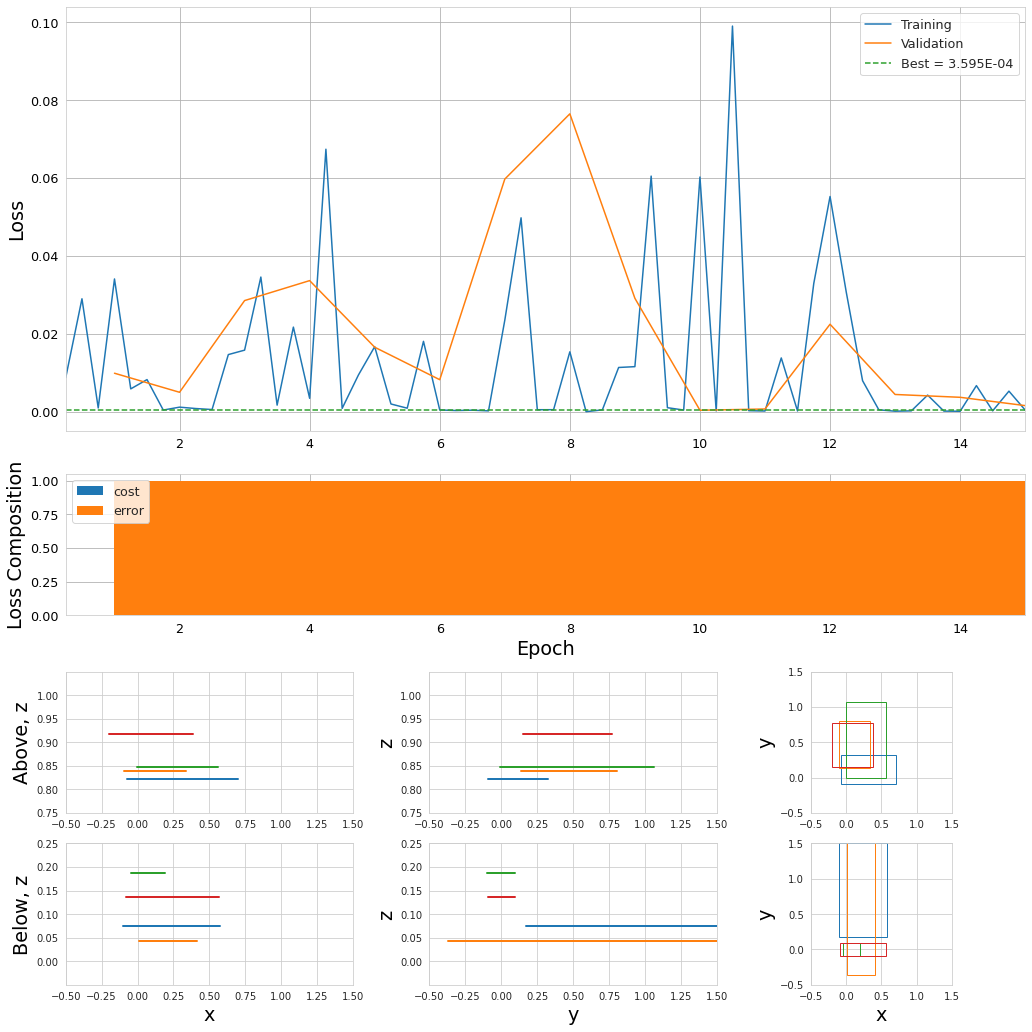

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Automatically setting cost coefficient to 0.008695357479155064


/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid ins

CostCoefWarmup: Warmed up, average error = tensor([0.0138])
PanelOptConfig: Optimiser warm-up completed
+-------------+-------------+----------------------+
|    Param    | Median Grad |          LR          |
+-------------+-------------+----------------------+
|  xy_pos_opt | 0.007650843 |  1.3070455299615462  |
|  z_pos_opt  |  0.4796619  | 0.010424008823231726 |
| xy_span_opt | 0.013447502 |  0.7436325516503921  |
+-------------+-------------+----------------------+


/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid ins

<Figure size 1024x1024 with 0 Axes>

In [78]:
_ = wrapper.fit(n_epochs=15,
                passive_bs=1,
                n_mu_per_volume=250,
                mu_bs=50,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefWarmup(n_warmup=5), PanelOptConfig(n_warmup=5, xy_pos_rate=0.01, z_pos_rate=0.005, xy_span_rate=0.01), MuonResampler(), NoMoreNaNs(),PanelMetricLogger()])